*****************************************************************
#  Research paper
- Authors: Paul Koks, Izzie He, Lisanne van Vliet, Sam Slotemaker
- TAs: Sandro Barres-Hamers, Alexander Schmatz, Márton Bodó and Danae Mitsea.
*****************************************************************

Install the NLTK package:


In [1]:
!pip install nltk

In [28]:
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('subjectivity')
nltk.download('vader_lexicon')

import matplotlib.pyplot as plt
import numpy as np

[nltk_data] Downloading package subjectivity to
[nltk_data]     /home/samsloot/nltk_data...
[nltk_data]   Package subjectivity is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/samsloot/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
import csv

with open('datasets/comments/barbie_comments.csv', 'r') as file:
    csv_reader = csv.DictReader(file)
    data = [row for row in csv_reader]
    
# filter out responses
filteredComments = [a for a in data if a['text'][0] != '@']

totalScore = 0
totalAmount = 0
for comment in filteredComments:
    sentence = comment['text']
    
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(sentence)
    
    sentimentScore = ss['compound']
    commentLikes = float(comment['likeCount'])
    
    # make sentiment score weigh based on the amount of likes
    totalScore += sentimentScore * commentLikes
    totalAmount += 1 + commentLikes

# print(totalAmount)
print(totalScore / totalAmount)

0.44246970023674814


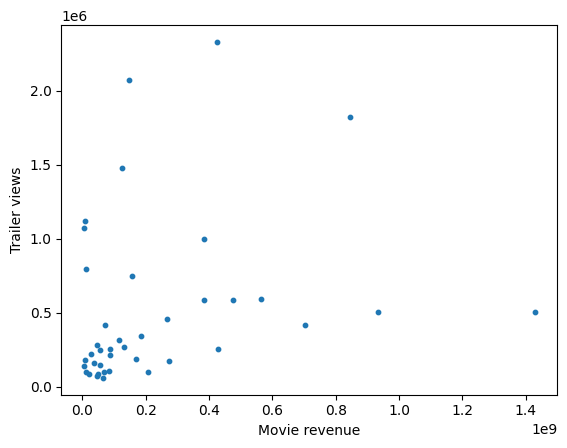

In [34]:
with open('datasets/40MoviesDataSet.csv', 'r') as file:
    csv_reader = csv.DictReader(file)
    movie_data = [row for row in csv_reader]

x =  [int(i['revenue']) for i in movie_data]
y =  [int(i['viewCount']) for i in movie_data]

plt.scatter(x, y, s=10)

plt.xlabel("Movie revenue")
plt.ylabel("Trailer views")

plt.show()